# Finding optimal hyper parameters for a CNN model

The point of this notebook is to obtain an optimal set of parameters for our CNN model to process time based series data. Specifically, we are processing IoT data from TON a well-kept dataset from The UNSW Group in Canberra, Australia.

The specific dataset being discussed here is the IoT Weather dataset.



We have pip install mealpy each time because it is not a default python package ,and every time the runtime refreshes; the package is uninstalled.

In [ ]:
%pip install mealpy==3.0.1
%pip install -U scikit-learn
%pip install imbalanced-learn
%pip install matplotlib
%pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.3/386.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 14.9 MB/s eta 0:00:00


Our main libraries used are:

*   Imblearn
*   Pandas
*   Matplot Lib
*   MealPy
*   Numpy
*   SKLearn
*   Tensorflow
*   Time


In [ ]:
import pandas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from imblearn.combine import SMOTETomek
import numpy
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
from mealpy import FloatVar, LCO
import time

# Preparing the Datasets for the CNN Model

We split off the information that indicates whether or not an attack has occured (*label*) and the types of attacks (*type*).
Now there are three dataframes:
  X - all features
  y - attack or not
  y_type - type of attack

We split again into test and train data sets and include some randomness.
**Reset_index** drops the indexes from these new dataframes.
Next, we encode the text data, add another randomness, and scale all dataframes. The X dataframe is reshaped.

In [ ]:
#Uncomment for local use
#raw_data = pandas.read_csv('../../Train_Test_IoT_dataset/Train_Test_IoT_Weather.csv')
#Uncomment for Google Colab
raw_data = pandas.read_csv('Train_Test_IoT_Weather.csv')
X = raw_data.drop(columns=['label','type'])
y = raw_data['label']
y_type = raw_data['type']

In [ ]:
# Binary
X_train, X_testsplit, y_train, y_testsplit = train_test_split(X, y, test_size=0.2, random_state=777)
# Binary validation
X_test, X_validation, y_test, y_validation = train_test_split(X_testsplit, y_testsplit, test_size=0.5, random_state=777)

#drop index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_validation = X_validation.reset_index(drop=True)
y_validation = y_validation.reset_index(drop=True)

In [ ]:
encoder = OrdinalEncoder()
label_encoder = LabelEncoder()
X_train_encode = encoder.fit_transform(X_train)
X_test_encode = encoder.fit_transform(X_test)
y_train_encode = label_encoder.fit_transform(y_train)
y_test_encode = label_encoder.fit_transform(y_test)
X_validation_encode = encoder.fit_transform(X_validation)
y_validation_encode = label_encoder.fit_transform(y_validation)

In [ ]:
smotetomek = SMOTETomek(random_state=777)
X_rebalance, y_rebalance = smotetomek.fit_resample(X_train_encode, y_train_encode)

In [ ]:
scaler = StandardScaler()
X_rebalance = scaler.fit_transform(X_rebalance)
X_test_encode = scaler.transform(X_test_encode)

X_validation_encode = scaler.transform(X_validation_encode)

In [ ]:
X_rebalance = X_rebalance.reshape(X_rebalance.shape[0], X_rebalance.shape[1], 1)
X_test_encode = X_test_encode.reshape(X_test_encode.shape[0], X_test_encode.shape[1], 1)

X_validation_encode = X_validation_encode.reshape(X_validation_encode.shape[0], X_validation_encode.shape[1], 1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 50)             200       
                                                                 
 max_pooling1d (MaxPooling1  (None, 1, 50)             0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 1, 50)             0         
                                                                 
 batch_normalization (Batch  (None, 1, 50)             200       
 Normalization)                                                  
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 flatten (Flatten)           (None, 64)                0

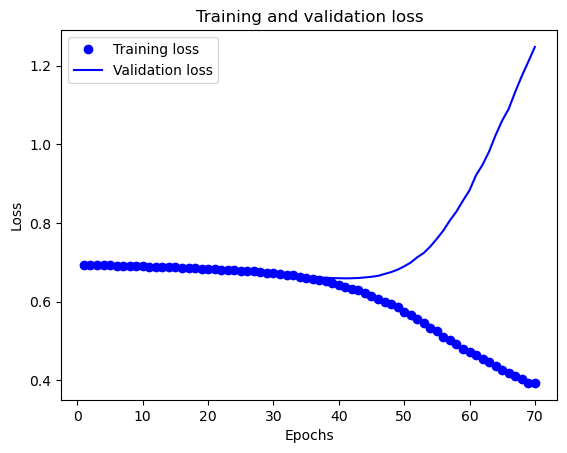

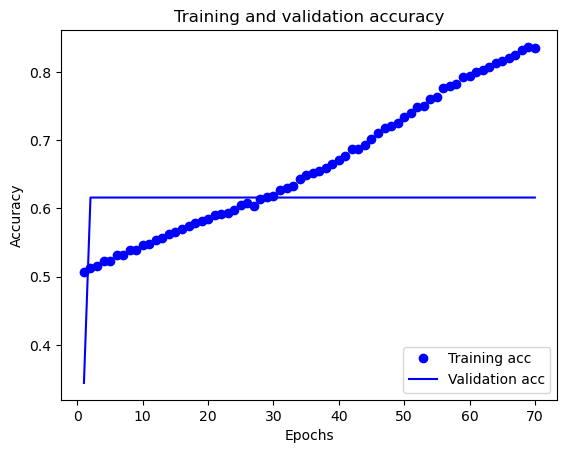


Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1522
           1       0.61      1.00      0.76      2404

    accuracy                           0.61      3926
   macro avg       0.31      0.50      0.38      3926
weighted avg       0.37      0.61      0.47      3926


Confusion Matrix
[[   0 1522]
 [   0 2404]]


c:\Users\User1\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User1\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User1\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


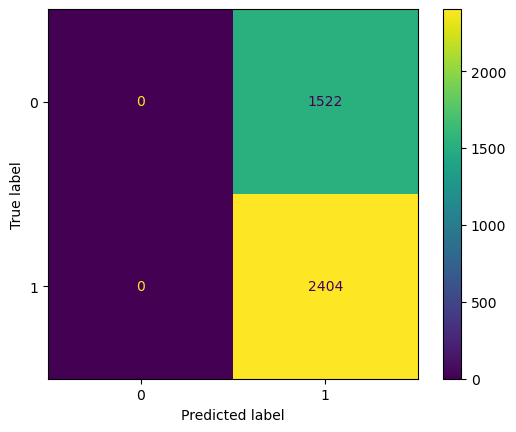

Time taken: 173.0972 seconds


In [ ]:
start_time_1 = time.perf_counter()
with tensorflow.device('/device:GPU:0'):
  # CNN model detection
  # https://keras.io/api/layers/activations/#softmax-function
  detection_model = tensorflow.keras.Sequential([
      tensorflow.keras.layers.Input(shape=(X_rebalance.shape[1],X_rebalance.shape[2])),
      tensorflow.keras.layers.Conv1D(filters=50, kernel_size=3, activation='sigmoid'),
      tensorflow.keras.layers.MaxPooling1D(pool_size=2),
      tensorflow.keras.layers.Dropout(0.3),
      tensorflow.keras.layers.BatchNormalization(),
      tensorflow.keras.layers.LSTM(64),
      tensorflow.keras.layers.Flatten(),
      # 1 layer
      tensorflow.keras.layers.Dense(512, activation='relu'),
      tensorflow.keras.layers.Dropout(0.5),
      # either attack or normal
      tensorflow.keras.layers.Dense(1, activation='sigmoid')
  ])

  detection_model.summary()
  # https://keras.io/api/losses/probabilistic_losses/#probabilistic-losses
  sgd = tensorflow.keras.optimizers.SGD(learning_rate=0.001)
  detection_model.compile(optimizer=sgd,
                loss=tensorflow.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

  history = detection_model.fit(X_rebalance, y_rebalance, batch_size=64, epochs=70, validation_data=(X_validation_encode, y_validation_encode))
  test_loss, test_acc = detection_model.evaluate(X_test_encode, y_test_encode)

  # Make predictions
  prediction = detection_model.predict(X_test_encode)
  print(prediction)
  attack_prediction = numpy.where(prediction > 0.5, 1, 0)
  print(attack_prediction)
  print(y_test)

  # Evaluate the model
  print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}\n")
  # https://www.tensorflow.org/tutorials/keras/text_classification for training and validation loss and accuracy
  history_dict = history.history
  # print(history_dict.keys())
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  print("\n")

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

  print("\nClassification Report")
  print(classification_report(y_test, attack_prediction))

  print("\nConfusion Matrix")
  print(confusion_matrix(y_test, attack_prediction))
  ConfusionMatrixDisplay.from_predictions(y_test, attack_prediction)
  plt.show()

end_time1 = time.perf_counter()
print(f"Time taken: {end_time1 - start_time_1:0.4f} seconds")

# Optimizing the model
Instead of looking at random number ranges for learning rates, filters, and hidden units, we have encoded specific values.

The hyper parameters we are attempting to optimize are:

*   Batch Size
*   Activation Functions
*   Learning Rates
*   Filters
*   Hidden Units


The base CNN model we made is ingested into *objective_function*.
  This is where our hyper parameters are being considered.
  It returns the Accuracy of that particular iteration.
**LB** and **UB** is set according to the list given above.



2025/04/12 09:40:50 PM, INFO, mealpy.human_based.LCO.OriginalLCO: Solving single objective optimization problem.


Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.45695364475250244
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.7231278717517853
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598

2025/04/12 10:12:21 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 1, Current best: 0.38410598039627075, Global best: 0.38410598039627075, Runtime: 993.16687 seconds


Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075


2025/04/12 10:29:21 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 2, Current best: 0.38410598039627075, Global best: 0.38410598039627075, Runtime: 1019.60570 seconds


Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075


2025/04/12 10:48:20 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 3, Current best: 0.38410598039627075, Global best: 0.38410598039627075, Runtime: 1139.68291 seconds


Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075


2025/04/12 11:06:23 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 4, Current best: 0.38410598039627075, Global best: 0.38410598039627075, Runtime: 1082.30179 seconds


Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.41365259885787964


2025/04/12 11:22:38 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 5, Current best: 0.38410598039627075, Global best: 0.38410598039627075, Runtime: 975.72475 seconds


Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.34666329622268677
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38767194747924805
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075


2025/04/12 11:38:43 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 6, Current best: 0.34666329622268677, Global best: 0.34666329622268677, Runtime: 964.72126 seconds


Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075


2025/04/12 11:56:02 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 7, Current best: 0.34666329622268677, Global best: 0.34666329622268677, Runtime: 1039.20187 seconds


Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.5998471677303314
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075


2025/04/13 12:12:17 AM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 8, Current best: 0.34666329622268677, Global best: 0.34666329622268677, Runtime: 974.93816 seconds


Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075


2025/04/13 12:27:59 AM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 9, Current best: 0.34666329622268677, Global best: 0.34666329622268677, Runtime: 941.55195 seconds


Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075


2025/04/13 12:43:28 AM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 10, Current best: 0.34666329622268677, Global best: 0.34666329622268677, Runtime: 929.02255 seconds


Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075


2025/04/13 12:56:37 AM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 11, Current best: 0.34666329622268677, Global best: 0.34666329622268677, Runtime: 789.46299 seconds


Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.18160980939865112
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516


2025/04/13 01:09:37 AM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 12, Current best: 0.18160980939865112, Global best: 0.18160980939865112, Runtime: 779.79568 seconds


Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.6158940494060516
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075


2025/04/13 01:23:30 AM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 13, Current best: 0.18160980939865112, Global best: 0.18160980939865112, Runtime: 833.30103 seconds


Accuracy 0.38410598039627075
Accuracy 0.0845644474029541
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.2557310461997986
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075


2025/04/13 01:36:52 AM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 14, Current best: 0.0845644474029541, Global best: 0.0845644474029541, Runtime: 802.01233 seconds


Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075


2025/04/13 01:50:17 AM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 15, Current best: 0.0845644474029541, Global best: 0.0845644474029541, Runtime: 804.65824 seconds


Accuracy 0.38410598039627075
Solution: [1.13791837 1.51978211 0.         1.18961266 0.23336963], Fitness: 0.0845644474029541
Solution: [1.13791837 1.51978211 0.         1.18961266 0.23336963], Fitness: 0.0845644474029541


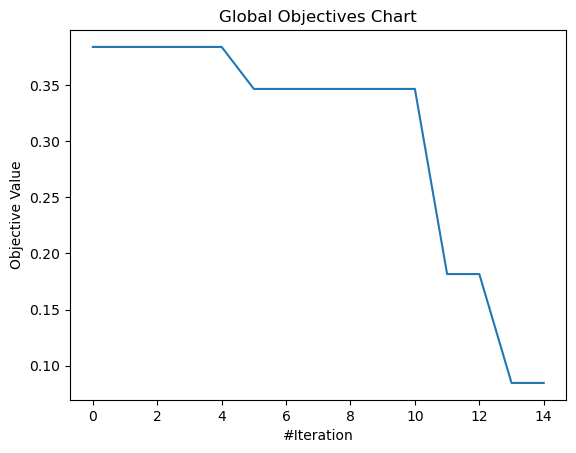

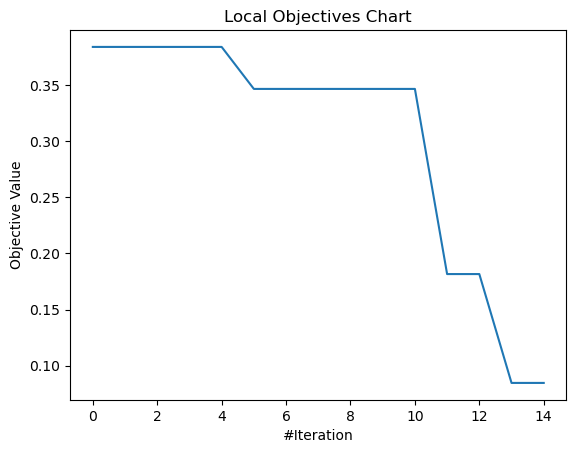

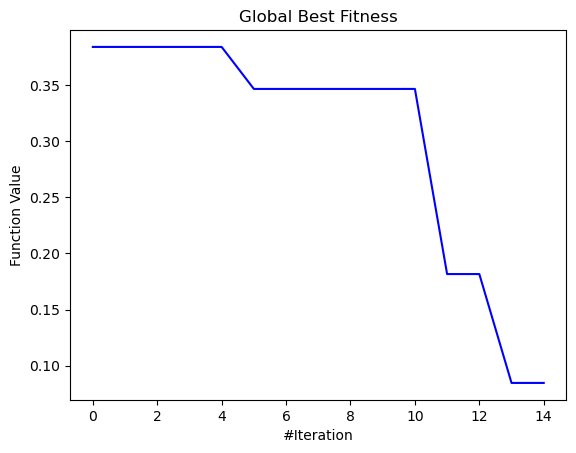

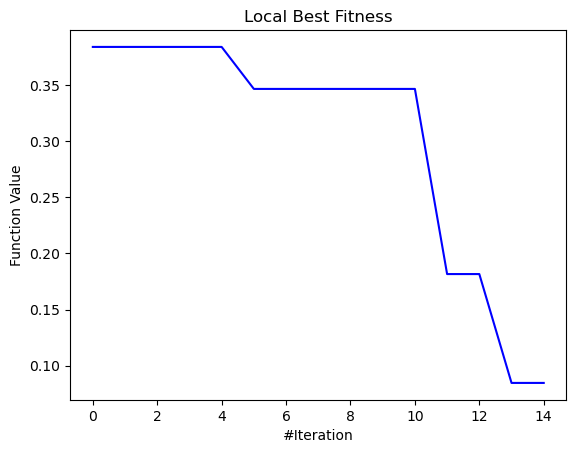

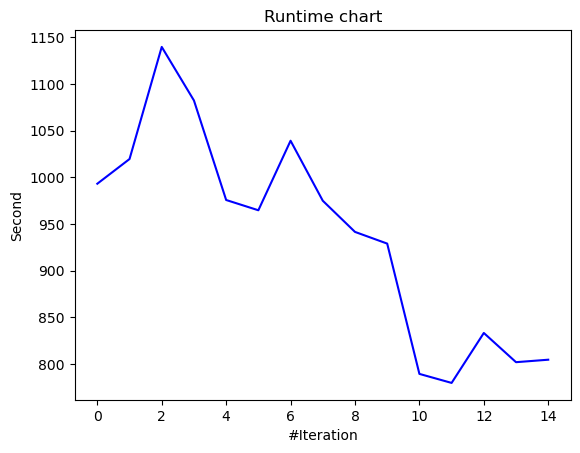

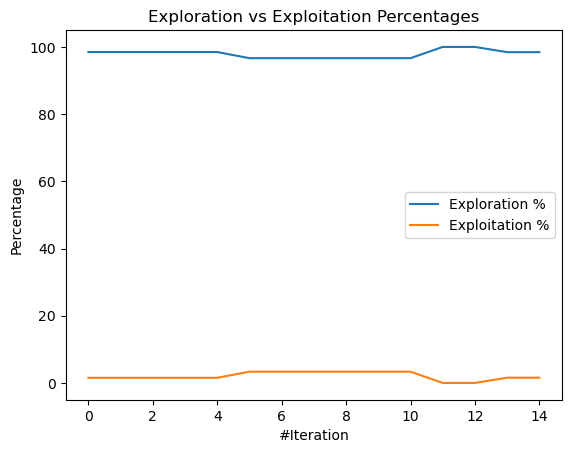

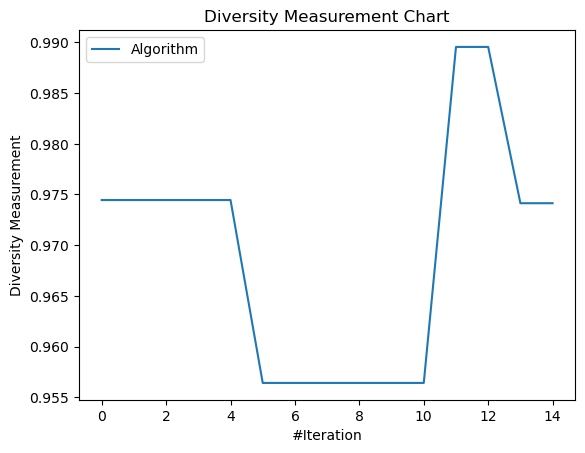

In [ ]:
BATCH_ENCODER = LabelEncoder()
BATCH_ENCODER.fit([32, 64, 128])

#act encoder --> Which activation function should be used?
ACT_ENCODER = LabelEncoder()
ACT_ENCODER.fit(['softmax', 'softplus', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'])

#Learning Rate encoder
LR_ENCODER = LabelEncoder()
LR_ENCODER.fit([0.0005, 0.001, 0.005, 0.01, 0.05, 0.1])

#Filter encoder
FILTER_ENCODER = LabelEncoder()
FILTER_ENCODER.fit([25, 50, 75])

#Hidden Units encoder
HIDDEN_ENCODER = LabelEncoder()
HIDDEN_ENCODER.fit([400, 512, 640])

def objective_function(params):
  '''RULES:
      Batch Size - 32, 64, 128
      Activation - softmax, softplus, relu, tanh, sigmoid, hard_sigmoid, linear
      Learning Rate - 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1
      Filters - 25, 50, 75
      Hidden Units - 400, 512, 640
      Dense Layers - 5, 8, 10
  '''
  batch_size = BATCH_ENCODER.inverse_transform([int(params[0])])[0]
  activation = ACT_ENCODER.inverse_transform([int(params[1])])[0]
  learning_rate = LR_ENCODER.inverse_transform([int(params[2])])[0]
  filter = FILTER_ENCODER.inverse_transform([int(params[3])])[0]
  hidden_units = HIDDEN_ENCODER.inverse_transform([int(params[4])])[0]

  model = tensorflow.keras.Sequential()
  model.add(tensorflow.keras.layers.Input(shape=(X_rebalance.shape[1], X_rebalance.shape[2]))),
  model.add(tensorflow.keras.layers.Conv1D(filters=filter, kernel_size=3, activation='sigmoid')),
  model.add(tensorflow.keras.layers.MaxPooling1D(pool_size=2)),
  model.add(tensorflow.keras.layers.Dropout(0.3)),
  model.add(tensorflow.keras.layers.BatchNormalization()),
  model.add(tensorflow.keras.layers.LSTM(64)),
  model.add(tensorflow.keras.layers.Flatten()),
  model.add(tensorflow.keras.layers.Dense(int(hidden_units), activation=activation)),
  model.add(tensorflow.keras.layers.Dropout(0.5)),
  model.add(tensorflow.keras.layers.Dense(1, activation='sigmoid'))


  optimizer = tensorflow.keras.optimizers.SGD(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

  history = model.fit(X_rebalance, y_rebalance, batch_size=batch_size, epochs=15, validation_data=(X_validation_encode, y_validation_encode), verbose=0)
  min_validation_accuracy = 1-history.history['val_accuracy'][-1]
  print(f"Accuracy {min_validation_accuracy}")
  return min_validation_accuracy

LB = [0, 0, 0, 0, 0]
UB = [2.99, 6.99, 5.99, 2.99, 2.99]

problem_dict = {
    "obj_func": objective_function,
    "bounds": FloatVar(lb=LB, ub=UB),
    "minmax": "min",
    "verbose": True
}

model = LCO.OriginalLCO(epoch=15, pop_size=20)
g_best = model.solve(problem_dict)
print(f"Solution: {g_best.solution}, Fitness: {g_best.target.fitness}")
print(f"Solution: {model.g_best.solution}, Fitness: {model.g_best.target.fitness}")
model.history.save_global_objectives_chart(filename="hello/goc")
model.history.save_local_objectives_chart(filename="hello/loc")

model.history.save_global_best_fitness_chart(filename="hello/gbfc")
model.history.save_local_best_fitness_chart(filename="hello/lbfc")

model.history.save_runtime_chart(filename="hello/rtc")

model.history.save_exploration_exploitation_chart(filename="hello/eec")

model.history.save_diversity_chart(filename="hello/dc")


Solution: [1.13791837 1.51978211 0.         1.18961266 0.23336963], Fitness: 0.0845644474029541


Batch Size - 32, **64**, 128

Activation - softmax, **softplus**, relu, tanh, sigmoid, hard_sigmoid, linear

Learning Rate - **0.0005**, 0.001, 0.005, 0.01, 0.05, 0.1

Filters - 25, **50**, 75

Hidden Units - **400**, 512, 640

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 3, 50)          │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 50)          │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 400)            │        26,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           401 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,241 (219.69 KB)

 Trainable params: 56,141 (219.30 KB)

 Non-trainable params: 100 (400.00 B)

Epoch 1/70
608/608 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.4957 - loss: 0.8024 - val_accuracy: 0.6159 - val_loss: 0.6902
Epoch 2/70
608/608 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5036 - loss: 0.7877 - val_accuracy: 0.6159 - val_loss: 0.6907
Epoch 3/70
608/608 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5020 - loss: 0.7861 - val_accuracy: 0.3841 - val_loss: 0.7002
Epoch 4/70
608/608 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5005 - loss: 0.7831 - val_accuracy: 0.3841 - val_loss: 0.6938
Epoch 5/70
608/608 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4975 - loss: 0.7772 - val_accuracy: 0.6159 - val_loss: 0.6860
Epoch 6/70
608/608 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4997 - loss: 0.7702 - val_accuracy: 0.6159 - val_loss: 0.6863
Epoch 7/70
608/608 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4966 - loss: 0.7695 - val_accuracy: 0.6159 - val_loss: 0.6898
Epoch 8/70
608/608 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5024 - loss: 0.7639 - val_accuracy: 0

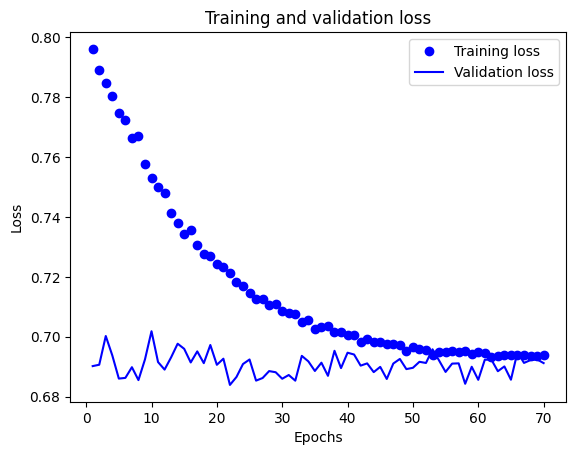

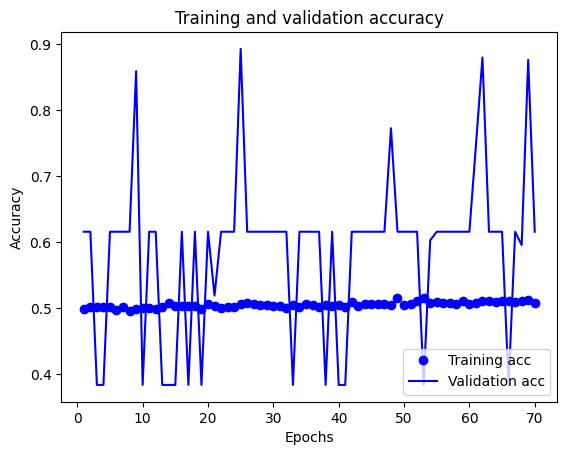


Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1522
           1       0.61      1.00      0.76      2404

    accuracy                           0.61      3926
   macro avg       0.31      0.50      0.38      3926
weighted avg       0.37      0.61      0.47      3926


Confusion Matrix
[[   0 1522]
 [   0 2404]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


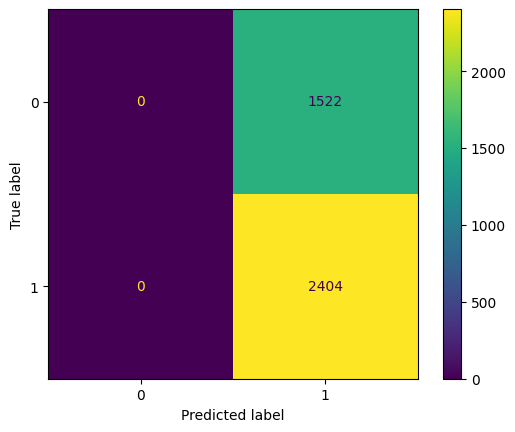

Time taken: 386.2728 seconds


In [ ]:
start_time_2 = time.perf_counter()
with tensorflow.device('/device:GPU:0'):
  # CNN model detection
  # https://keras.io/api/layers/activations/#softmax-function
  detection_model = tensorflow.keras.Sequential([
      tensorflow.keras.layers.Input(shape=(X_rebalance.shape[1],X_rebalance.shape[2])),
      tensorflow.keras.layers.Conv1D(filters=50, kernel_size=3, activation='sigmoid'),
      tensorflow.keras.layers.MaxPooling1D(pool_size=2),
      tensorflow.keras.layers.Dropout(0.3),
      tensorflow.keras.layers.BatchNormalization(),
      tensorflow.keras.layers.LSTM(64),
      tensorflow.keras.layers.Flatten(),
      # 1 layer
      tensorflow.keras.layers.Dense(400, activation='softplus'),
      tensorflow.keras.layers.Dropout(0.5),
      # either attack or normal
      tensorflow.keras.layers.Dense(1, activation='sigmoid')
  ])

  detection_model.summary()
  # https://keras.io/api/losses/probabilistic_losses/#probabilistic-losses
  sgd = tensorflow.keras.optimizers.SGD(learning_rate=0.0005)
  detection_model.compile(optimizer=sgd,
                loss=tensorflow.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

  history = detection_model.fit(X_rebalance, y_rebalance, batch_size=64, epochs=70, validation_data=(X_validation_encode, y_validation_encode))
  test_loss, test_acc = detection_model.evaluate(X_test_encode, y_test_encode)

  # Make predictions
  prediction = detection_model.predict(X_test_encode)
  print(prediction)
  attack_prediction = numpy.where(prediction > 0.5, 1, 0)
  print(attack_prediction)
  print(y_test)

  # Evaluate the model
  print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}\n")
  # https://www.tensorflow.org/tutorials/keras/text_classification for training and validation loss and accuracy
  history_dict = history.history
  # print(history_dict.keys())
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  print("\n")

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

  print("\nClassification Report")
  print(classification_report(y_test, attack_prediction))

  print("\nConfusion Matrix")
  print(confusion_matrix(y_test, attack_prediction))
  ConfusionMatrixDisplay.from_predictions(y_test, attack_prediction)
  plt.show()

end_time2 = time.perf_counter()
print(f"Time taken: {end_time2 - start_time_2:0.4f} seconds")
